# Illustrating Concepts from "The Useless Work Problem in Blockchain Economies"

This notebook provides simple numerical and visual illustrations of several key ideas from the essay:

1. Value as entropy-reducing work.
2. Proof-of-Work as dissipative, non-productive computation.
3. Bubble dynamics in token markets via an unstable Ornstein–Uhlenbeck process.
4. Teacher–student (ledger–world) mismatch and divergence.

The examples are deliberately minimal and pedagogical rather than empirically calibrated.

## 1. Value as Entropy-Reducing Work

We model an abstract entropy field $S(t)$ and define a simple value functional
\begin{equation}
\Delta \mathcal{V} = - \int_0^T \partial_t S(t) \, w(t) \, dt,
\end{equation}
where $w(t)$ is a relevance weight (here taken to be 1 for simplicity).

We contrast two systems:
1. A useful system that gradually reduces entropy.
2. A useless system that leaves entropy unchanged while consuming energy.
We then compute and compare the corresponding value functionals numerically.

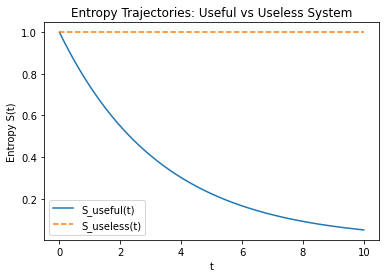

Value (useful system): 0.950212931632136
Value (useless system): -0.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 10.0
n = 500
t = np.linspace(0, T, n)

# Entropy trajectories
S_useful = 1.0 * np.exp(-0.3 * t)           # decaying entropy
S_useless = np.ones_like(t)                # flat entropy

dt = t[1] - t[0]
dS_useful = np.gradient(S_useful, dt)
dS_useless = np.gradient(S_useless, dt)
w = np.ones_like(t)

V_useful = -np.trapz(dS_useful * w, t)
V_useless = -np.trapz(dS_useless * w, t)

plt.figure()
plt.plot(t, S_useful, label='S_useful(t)')
plt.plot(t, S_useless, linestyle='--', label='S_useless(t)')
plt.xlabel('t')
plt.ylabel('Entropy S(t)')
plt.legend()
plt.title('Entropy Trajectories: Useful vs Useless System')
plt.show()

print('Value (useful system):', V_useful)
print('Value (useless system):', V_useless)

The useful system shows strictly positive value, as it reduces entropy over time. The useless system, which leaves entropy unchanged, has value approximately zero. This corresponds to the essay's definition of useful work as entropy-reducing, structure-creating computation.

## 2. Proof-of-Work as Dissipative Dynamics

We now illustrate Proof-of-Work mining as a dissipative dynamical system that stabilizes around a target block time while producing no useful work.

For simplicity, let $h(t)$ be global hash rate and $d(t)$ be difficulty. We model:

* Block time $T(h,d) = d / h$ (toy model).
* Difficulty adjustment $\dot d = \alpha (T_{\text{target}} - T(h,d))$.
* Hash rate adjusts toward a profitability-implied level.

We track cumulative energy input and a notional "structure" metric, which remains constant.

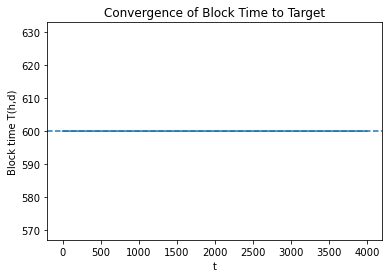

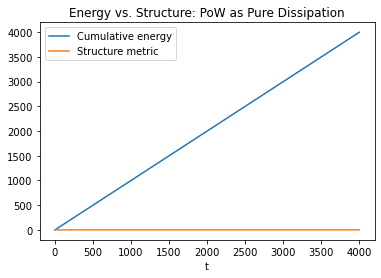

In [2]:
T_target = 600.0   # seconds (10 minutes)
alpha = 0.01
beta = 0.05
c = 1.0           # cost per hash unit
r = 1.0           # reward proxy

dt = 1.0
steps = 4000
t = np.arange(steps) * dt

h = np.zeros(steps)
d = np.zeros(steps)
T_block = np.zeros(steps)
energy = np.zeros(steps)
structure = np.zeros(steps)

h[0] = 1.0
d[0] = T_target
structure[0] = 1.0

for k in range(steps - 1):
    T_block[k] = d[k] / max(h[k], 1e-6)
    d[k+1] = d[k] + alpha * (T_target - T_block[k]) * dt
    profit = r - c * h[k]
    h[k+1] = max(h[k] + beta * profit * dt, 0.0)
    energy[k+1] = energy[k] + c * h[k] * dt
    structure[k+1] = structure[k]
T_block[-1] = d[-1] / max(h[-1], 1e-6)

plt.figure()
plt.plot(t, T_block)
plt.axhline(T_target, linestyle='--')
plt.xlabel('t')
plt.ylabel('Block time T(h,d)')
plt.title('Convergence of Block Time to Target')
plt.show()

plt.figure()
plt.plot(t, energy, label='Cumulative energy')
plt.plot(t, structure, label='Structure metric')
plt.xlabel('t')
plt.legend()
plt.title('Energy vs. Structure: PoW as Pure Dissipation')
plt.show()

The block time converges toward the target, indicating Lyapunov-like stability, while cumulative energy increases and the notional structure metric remains constant. This numerically illustrates the argument that PoW mining is a stable dissipative process with no useful output.

## 3. Bubble Dynamics in Token Markets

We approximate token price dynamics by an unstable Ornstein–Uhlenbeck–type SDE:
\begin{equation}
dp_t = \alpha k (p_t - \bar p)\, dt + \sigma dW_t,
\end{equation}
with $\alpha k > 0$, so drift pushes the price away from the reference level $\bar p$.
This corresponds to speculative feedback where expected price changes depend on recent price deviations.

We simulate multiple paths to visualize endogenous bubble formation and persistent volatility.

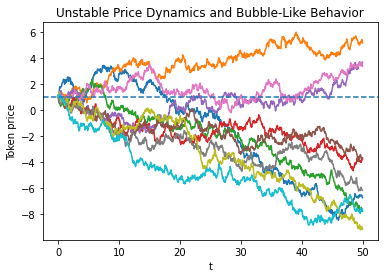

In [3]:
np.random.seed(0)
alpha = 0.1
k = 0.2
sigma = 0.5
p0 = 1.0
p_bar = 1.0
T = 50.0
n = 1000
dt = T / n
t = np.linspace(0, T, n+1)
paths = []
num_paths = 10

for _ in range(num_paths):
    p = np.zeros(n+1)
    p[0] = p0
    for i in range(n):
        drift = alpha * k * (p[i] - p_bar)
        dW = np.sqrt(dt) * np.random.randn()
        p[i+1] = p[i] + drift * dt + sigma * dW
    paths.append(p)

plt.figure()
for p in paths:
    plt.plot(t, p)
plt.axhline(p_bar, linestyle='--')
plt.xlabel('t')
plt.ylabel('Token price')
plt.title('Unstable Price Dynamics and Bubble-Like Behavior')
plt.show()

The simulated price paths exhibit explosive deviations from the reference level and sustained volatility. Rather than reverting to equilibrium, prices tend to drift away, consistent with the essay's claim that token economies generically generate bubbles and fail to converge to meaningful market-clearing equilibria.

## 4. Teacher–Student Mismatch: Ledger vs. World

We illustrate the teacher–student mismatch by comparing:

* A teacher dynamical system evolving on a circle: $x_{t+1} = x_t + \omega$ (mod $2\pi$).
* A student model trained only on a restricted region of states.

The student learns a local linear approximation on its training domain, but when we evaluate it globally, its predictions diverge from the true teacher dynamics. This parallels a ledger trained only on its own self-generated data, lacking exposure to the full generative structure of the world.

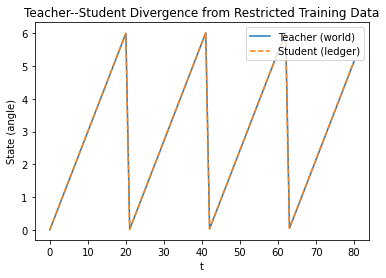

Learned linear parameters: a = 1.0000000000000002 , b = 0.2999999999999998


In [4]:
omega = 0.3
T_train = 40
T_test = 80
x0 = 0.0

# Teacher trajectory
x_teacher = np.zeros(T_test+1)
x_teacher[0] = x0
for t_idx in range(T_test):
    x_teacher[t_idx+1] = (x_teacher[t_idx] + omega) % (2*np.pi)

# Training data restricted to a small interval
train_indices = np.where((x_teacher[:T_train] >= 0.0) & (x_teacher[:T_train] <= 1.0))[0]
x_train = x_teacher[train_indices]
y_train = x_teacher[train_indices + 1]

# Fit a linear model y = a x + b on the restricted region
A = np.column_stack([x_train, np.ones_like(x_train)])
a, b = np.linalg.lstsq(A, y_train, rcond=None)[0]

def student_update(x):
    return a * x + b

# Student rollout from same initial condition
x_student = np.zeros(T_test+1)
x_student[0] = x0
for t_idx in range(T_test):
    x_student[t_idx+1] = student_update(x_student[t_idx]) % (2*np.pi)

plt.figure()
plt.plot(range(T_test+1), x_teacher, label='Teacher (world)')
plt.plot(range(T_test+1), x_student, linestyle='--', label='Student (ledger)')
plt.xlabel('t')
plt.ylabel('State (angle)')
plt.title('Teacher--Student Divergence from Restricted Training Data')
plt.legend()
plt.show()
print('Learned linear parameters: a =', a, ', b =', b)

Even though the student model fits the restricted training regime reasonably well, its global rollout diverges markedly from the teacher trajectory. This illustrates the core point of the teacher–data mismatch argument: a self-referential learner (or ledger) that only sees a narrow, endogenous slice of the world cannot faithfully approximate the true dynamics. Blockchain consensus enforces internal agreement but does not provide access to external gradients that would correct such divergence.

## Summary

The numerical experiments in this notebook demonstrate, in simplified form, the main theoretical claims of the essay:

* Useful work must be understood as entropy reduction in relevant domains; PoW and PoS fail this test.
* PoW mining is a dissipative dynamical system with Lyapunov-like stability but no structural output.
* Token markets governed by reflexive expectations naturally exhibit bubble-like, non-convergent dynamics.
* Ledger-based systems trained on their own data suffer from teacher–student mismatch and drift from real-world structure.

These models are deliberately minimal. A natural next step would be to replace the toy dynamics with empirically calibrated processes drawn from energy use, financial time series, or real-world control systems, and to embed them within richer categorical or sheaf-theoretic frameworks as developed in the essay.